# Assignment 2 - Part (A) : Naive Bayes

<hr>

* In this part I have implemented Naive bayes from scratch for sentiment analysis on twitter dataset. 


* In this part I have worked on the [this](http://help.sentiment140.com/for-students) Dataset.

In [0]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
import random
import re 
from time import time
import pickle

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

from joblib import Parallel, delayed
import multiprocessing

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from scipy.stats import boxcox
from sklearn.preprocessing import  StandardScaler

## Part (a) : Implementing Naive Bayes and getting accuracy on Train and Test Datasets.

* In this part I have implemented Naive Bayes class that will be used in all the consecutive parts of the question.


* In this part I have computerd thetas for all the words in the vocabulary for both output classes 0 and 4.


* I have also incorporated various flags like addBigrams, addTrigrams and addPOS that will add features as mentioned in part e.


* I have also created one metric class that will compute various performence metrics for our model like accuracy score, confusion matrix and ROC curve.

In [0]:
class NaiveBayes:
    
    dict0, dict4 = dict(), dict()
    phi0, phi4, = 0, 0
    n0, n4, = 0, 0
    vocab=list()
    v=0
    splitString = ',|\.| '
    tt=TweetTokenizer(preserve_case=False, strip_handles=True)
    simpleTokenizer = lambda self,s : [word for word in re.split(self.splitString, s) if word!='' ]
    tokenizer = simpleTokenizer
    
    tweetTok = lambda self,s : self.tt.tokenize(s)
    
    def __init__(self, useTweetTokenizer=False, addBigrams=False, addTrigrams=False, addPOS=False):
        dict0, dict4 = dict(), dict()
        if useTweetTokenizer:
            self.tokenizer = self.tweetTok
        self.addBigrams = addBigrams
        self.addTrigrams = addTrigrams
        self.addPOS = addPOS
        
    def fit(self, X_train, Y_train):
        #----Creating vocabulary-----
        st = set()
        
        def getPOS(doc):
            words = self.tokenizer(doc)
            if words!=[]:
                return list((list(zip(*nltk.pos_tag(words))))[0])
            else:
                return []

        if self.addPOS:
            pos_lst = Parallel(n_jobs=6)(delayed(getPOS)(doc) for doc in tqdm(X_train, desc='Generating POS List'))
        
        for (doc,j) in tqdm(list(zip(X_train, range(len(X_train)))), desc='Generating Vocabulary'):
            words = self.tokenizer(doc)
            for word in words:
                st.add(word)
            if self.addBigrams:
                for i in range(len(words)-1):
                    st.add(words[i]+' '+words[i+1])
            if self.addTrigrams:
                for i in range(len(words)-2):
                    st.add(words[i]+' '+words[i+1]+' '+words[i+2])
            if self.addPOS:
                for pos in pos_lst[j]:
                    st.add(pos)
        self.vocab = list(st) # List of vocabulary
        self.v=len(self.vocab) #Vocabulary size
    
        #Splitting Dataset According to label
        X_train_0 = np.array(X_train)[np.where(Y_train == 0)]
        X_train_4 = np.array(X_train)[np.where(Y_train == 4)]

        #Creating empty dictionaries for every class
        self.dict0 = dict(zip(self.vocab, np.ones(len(self.vocab), dtype=int)))
        self.dict4 = dict(zip(self.vocab, np.ones(len(self.vocab), dtype=int)))

        #Counting occurance of each word in all three classes and then updating 
        #corrsponding dictionary
        for stat, j in tqdm(list(zip(X_train_0, range(len(X_train_0)))), desc='Generating Theta List for Label=0'):
            words = self.tokenizer(stat)
            for word in words:
                self.dict0[word] = self.dict0[word]+1
            if self.addBigrams:
                for i in range(len(words)-1):
                    bGram = words[i]+' '+words[i+1]
                    self.dict0[bGram] += 1
            if self.addTrigrams:
                for i in range(len(words)-2):
                    tGram = words[i]+' '+words[i+1]+' '+words[i+2]
                    self.dict0[tGram] += 1
            if self.addPOS:
                for pos in pos_lst[j]:
                    self.dict0[pos] += 1
        for stat, j in tqdm(list(zip(X_train_4, range(len(X_train_4)))), desc='Generating Theta List for Label=4'):
            words = self.tokenizer(stat)
            for word in words:
                self.dict4[word] = self.dict4[word]+1
            if self.addBigrams:
                for i in range(len(words)-1):
                    bGram = words[i]+' '+words[i+1]
                    self.dict4[bGram] += 1
            if self.addTrigrams:
                for i in range(len(words)-2):
                    tGram = words[i]+' '+words[i+1]+' '+words[i+2]
                    self.dict4[tGram] += 1
            if self.addPOS:
                for pos in pos_lst[j]:
                    self.dict4[pos] += 1
        
        #----Finding number of words in all these three classes
        self.n0 = sum(list(self.dict0.values()))
        self.n4 = sum(list(self.dict4.values()))
        
        self.dict0 = dict(zip(self.dict0.keys(), np.log(np.array(list(self.dict0.values()), dtype=int)/(self.n0+self.v))))
        self.dict4 = dict(zip(self.dict4.keys(), np.log(np.array(list(self.dict4.values()), dtype=int)/(self.n4+self.v))))
        
        
        #----Finding class priors
        self.phi0 = (X_train_0.shape[0]+1) / (X_train.shape[0]+2)
        self.phi4 = (X_train_4.shape[0]+1) / (X_train.shape[0]+2)

    def predict(self, X):
        pred_lst=list()
        
        for x, j in tqdm(list(zip(X,range(len(X)))), desc='Generating Predictions'):
            prob0 = math.log(self.phi0)
            prob4 = math.log(self.phi4)
            words = self.tokenizer(x)
            for word in words:
                prob0 += self.dict0.get(word) if self.dict0.get(word)!=None else math.log(1/(self.n0+self.v))
                prob4 += self.dict4.get(word) if self.dict4.get(word)!=None else math.log(1/(self.n4+self.v))
            if self.addBigrams:
                for i in range(len(words)-1):
                    bGram = words[i]+' '+words[i+1]
                    prob0 += self.dict0.get(bGram) if self.dict0.get(bGram)!=None else math.log(1/(self.n0+self.v))
                    prob4 += self.dict4.get(bGram) if self.dict4.get(bGram)!=None else math.log(1/(self.n4+self.v))
            if self.addTrigrams:
                for i in range(len(words)-2):
                    tGram = words[i]+' '+words[i+1]+' '+words[i+2]
                    prob0 += self.dict0.get(tGram) if self.dict0.get(tGram)!=None else math.log(1/(self.n0+self.v))
                    prob4 += self.dict4.get(tGram) if self.dict4.get(tGram)!=None else math.log(1/(self.n4+self.v))    
            if self.addPOS:
                for pos in (list(zip(*nltk.pos_tag(words)))[1]):
                    prob0 += self.dict0.get(pos) if self.dict0.get(pos)!=None else math.log(1/(self.n0+self.v))
                    prob4 += self.dict4.get(pos) if self.dict4.get(pos)!=None else math.log(1/(self.n4+self.v))
            pred_lst.append(4*(np.array([prob0, prob4]).argmax()))
        return pred_lst
    
    def predict_log_proba(self, X):
        log_proba0=list()
        log_proba4=list()
        
        for x, j in tqdm(list(zip(X,range(len(X)))), desc='Generating Log probabilities'):
            prob0 = math.log(self.phi0) #if self.phi0!=0 else 0
            prob4 = math.log(self.phi4) #if self.phi0!=0 else 0
            words = self.tokenizer(x)
            for word in words:
                prob0 += self.dict0.get(word) if self.dict0.get(word)!=None else np.log(1/(self.n0+self.v))
                prob4 += self.dict4.get(word) if self.dict4.get(word)!=None else np.log(1/(self.n4+self.v))
            if self.addBigrams:
                for i in range(len(words)-1):
                    bGram = words[i]+' '+words[i+1]
                    prob0 += self.dict0.get(bGram) if self.dict0.get(bGram)!=None else math.log(1/(self.n0+self.v))
                    prob4 += self.dict4.get(bGram) if self.dict4.get(bGram)!=None else math.log(1/(self.n4+self.v))
            if self.addTrigrams:
                for i in range(len(words)-2):
                    tGram = words[i]+' '+words[i+1]+' '+words[i+2]
                    prob0 += self.dict0.get(tGram) if self.dict0.get(tGram)!=None else math.log(1/(self.n0+self.v))
                    prob4 += self.dict4.get(tGram) if self.dict4.get(tGram)!=None else math.log(1/(self.n4+self.v))    
            if self.addPOS:
                for pos in (list(zip(*nltk.pos_tag(words)))[1]):
                    prob0 += self.dict0.get(pos) if self.dict0.get(pos)!=None else math.log(1/(self.n0+self.v))
                    prob4 += self.dict4.get(pos) if self.dict4.get(pos)!=None else math.log(1/(self.n4+self.v))
            log_proba0.append(prob0)
            log_proba4.append(prob4)
        return [log_proba0, log_proba4]
    
    def randomPred(self, size):
        choices = [0,4]
        pred = list()
        for x in range(size):
            pred.append(random.choice(choices))
        return pred
    
    def majorityPred(self, size, out=4):
        return [out]*size
        
    
    
class metrics:
    
    def accuracy_score(y_true, y_pred):
        true = list(y_true == y_pred).count(True)
        false = list(y_true == y_pred).count(False)
        return true*100/(true+false)
    
    def confusion_matrix(y_true, y_pred, title = 'Confusion Matrix'):
        cm=np.zeros((2,2), dtype=int)
        for (y_hat, y) in zip(y_pred, y_true):
            cm[y_hat//4][y//4] += 1
        
        sns.heatmap(cm, annot=True, fmt="d",linecolor='black',linewidth='0', \
        cmap='Blues',xticklabels=[0,4], yticklabels=[0,4], cbar=False)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(title)
        plt.show()

* **Loading the Dataset**

In [0]:
train_data = pd.read_csv('/content/drive/My Drive/ML/training.1600000.processed.noemoticon.csv', sep=',', encoding='latin-1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])

X_train = train_data['text']
Y_train = train_data['polarity'] 

test_data = pd.read_csv('/content/drive/My Drive/ML/testdata.manual.2009.06.14.csv', sep=',', encoding='latin-1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])

X_test = test_data['text']
Y_test = test_data['polarity']

X_test_new_0 = np.array(X_test)[np.where(Y_test==0)]# or Y_test==4)]
X_test_new_4 = np.array(X_test)[np.where(Y_test==4)]

X_test = np.concatenate((X_test_new_0, X_test_new_4))
Y_test = pd.Series(np.concatenate((np.zeros(X_test_new_0.shape[0]), np.zeros(X_test_new_4.shape[0])+4)), dtype=int)

* **Intererting finding :** Data contains duplicate Entries

In [4]:
vc = train_data[train_data.duplicated(subset=['id','text'], keep=False)]
print('Number of duplicate entries : ', len(vc))
vc.sort_values('id').head(10)

Number of duplicate entries :  3370


,polarity,id,date,query,user,text
213,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...
800261,4,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...
275,0,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...
800300,4,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...
989,0,1468053611,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,mariejamora,@hellobebe I also send some updates in plurk b...
801280,4,1468053611,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,mariejamora,@hellobebe I also send some updates in plurk b...
1177,0,1468100580,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,cristygarza,good night swetdreamss to everyonee and jare...
801573,4,1468100580,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,cristygarza,good night swetdreamss to everyonee and jare...
1254,0,1468115720,Mon Apr 06 23:48:00 PDT 2009,NO_QUERY,WarholGirl,@ientje89 aw i'm fine too thanks! yeah i miss ...
801650,4,1468115720,Mon Apr 06 23:48:00 PDT 2009,NO_QUERY,WarholGirl,@ientje89 aw i'm fine too thanks! yeah i miss ...


### Getting Accuracy on train and test data

In [5]:
nb_original=NaiveBayes()

nb_original.fit(X_train, Y_train)

train_pred = nb_original.predict(X_train)
print('Accuracy on Train Data : %.4f'%(metrics.accuracy_score(Y_train, train_pred)))

test_pred = nb_original.predict(X_test)
print('Accuracy on Test Data : %.4f'%(metrics.accuracy_score(Y_test, test_pred)))

Generating Predictions: 100%|██████████| 359/359 [00:00<00:00, 25570.25it/s]

Accuracy on Train Data : 84.8601
Accuracy on Test Data : 81.3370


## Part (b) : Getting base model accuracy by finding accuracy of test data using random prediction and majority vote prediction

In [6]:
nb=NaiveBayes()
random_pred = nb.randomPred(Y_test.shape[0])
print('Accuracy of Random predictor on Test Data (Attempt 1): ',metrics.accuracy_score(Y_test, random_pred))
random_pred = nb.randomPred(Y_test.shape[0])
print('Accuracy of Random predictor on Test Data (Attempt 2): ',metrics.accuracy_score(Y_test, random_pred))
random_pred = nb.randomPred(Y_test.shape[0])
print('Accuracy of Random predictor on Test Data (Attempt 3): ',metrics.accuracy_score(Y_test, random_pred))

majority_pred = nb.majorityPred(Y_test.shape[0], out=4)
print('Accuracy of Majority Vote(4) predictor on Test Data : ',metrics.accuracy_score(Y_test, majority_pred))
majority_pred = nb.majorityPred(Y_test.shape[0], out=0)
print('Accuracy of Majority Vote(0) predictor on Test Data : ',metrics.accuracy_score(Y_test, majority_pred))

Accuracy of Random predictor on Test Data (Attempt 1):  51.25348189415042
Accuracy of Random predictor on Test Data (Attempt 2):  47.910863509749305
Accuracy of Random predictor on Test Data (Attempt 3):  50.41782729805014
Accuracy of Majority Vote(4) predictor on Test Data :  50.69637883008357
Accuracy of Majority Vote(0) predictor on Test Data :  49.30362116991643


* Here we can see that our model gave test accuracy of 81.3370 and random and Majority vode predictor gave accuracies of around 50% hence our model is performing significantely better.


## Part (c) : Plotting Confusion matrix for the Train as well as Test Dataset for our Model

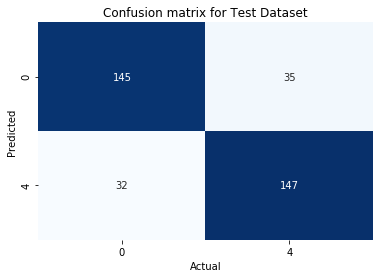

In [7]:
metrics.confusion_matrix(Y_test, test_pred, title='Confusion matrix for Test Dataset')

* **Observations from confusion matrix:**

    * Here we can see that diagonal entries are large as compared to non diagonal ones, hence our model is performing nice.
    * Also note that we have predicted 145 datapoints with y=0 out of total 177 datapoints, whereas we have predicted 147 datapoints with y=4 correctly from total of 182 datapoints, hence although we have less number for class=0 but ratio with total datapoints with particular class label is same, therefore TNR and TPR are 0.8192 and 0.8077(Considering 0 as negative label and 1 as positive label). Hence our model is performing well for both the labels.

## Part (d) : Stemming, Removing Stopwords and cleaning Data 

In this part I have preprocessed the original data and for that I have followed follwing steps.

1. Remove usernames
2. Remove stopwords
3. Stemming

This method uses 6 cores of my machine to clean data in parallel. and you can set flags as mentioned in the docstring of the method.

In [0]:
def cleanData(X, useTweetTokenizer=False, removeNot=False, usePorterStemmer=False):
    '''
        This method returns list of preprocessed text.
        
        **********
        Arguments:
            X : list of strings to clean
            useTweetTokenizer=False : Flag that mentiones which tokenizer to use.
                                        True : use nltk's TweetTokenizer
                                        False : re.split('\,|,| ',s)
            removeNot=False : Remove not and words like aren't isn't from stopwords.
            useProterStemmer=False : use Porter or snowball stemmer from nltk
        **********
    '''
    stop = set(stopwords.words('english')) #set of stopwords
    porter = nltk.stem.PorterStemmer()
    sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
    tt = TweetTokenizer(preserve_case=False, strip_handles=True)
    
    stemmer=sno
    if usePorterStemmer:
        stemmer=porter
    
    if removeNot:
        stop.remove('not')
        stop.remove('no')
        new_stop = set()
        for word in stop:
            if word.endswith('n\'t'):
                continue
            else:
                new_stop.add(word)
        stop = new_stop
    
    splitString = ',|\.| '
    
    def cleanUserName(sentence): #function to clean the word of any html-tags
        cleanr = re.compile('@\S*')
        cleantext = re.sub(cleanr, '', sentence)
        return cleantext
    
    simpleTok = lambda s : [x for x in re.split(splitString, cleanUserName(s)) if x!='']
    tweetTok = lambda s : tt.tokenize(s)
    
    tokenize = simpleTok
    if useTweetTokenizer:
        tokenize = tweetTok
    
    def cleanSingleDoc(sent):
        filtered_sentence=[]
        words = tokenize(sent)
        
        for word in words:
            if((len(word)>1 or word.isalpha()) & (word not in stop)):
                s=(stemmer.stem(word)).encode('utf-8')
                filtered_sentence.append(s)
            else:
                continue
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        return (str1.decode('utf-8'))
    
    final_string = Parallel(n_jobs=10)(delayed(cleanSingleDoc)(sent) for sent in tqdm(X, desc = 'Cleaning'))
    
    return np.array(final_string)

In [9]:
#Cleaning our dataset

X_train_cleaned = cleanData(X_train, useTweetTokenizer=True, removeNot=True, usePorterStemmer=True)
X_test_cleaned = cleanData(X_test, useTweetTokenizer=True, removeNot=True, usePorterStemmer=True)

Cleaning: 100%|██████████| 359/359 [00:00<00:00, 2237.25it/s]


In [10]:
#Getting Test accuracy on cleaned Data

nb_cleaned = NaiveBayes()

nb_cleaned.fit(X_train_cleaned, Y_train)

# train_pred_cleaned = nb_cleaned.predict(X_train_cleaned)
# print('Accuracy on Cleaned Train Data : %.4f %c'%(metrics.accuracy_score(Y_train, train_pred_cleaned),'%'))

test_pred_cleaned = nb_cleaned.predict(X_test_cleaned)
print('Accuracy on Cleaned Test Data : %.4f %c'%(metrics.accuracy_score(Y_test, test_pred_cleaned),'%'))

Generating Predictions: 100%|██████████| 359/359 [00:00<00:00, 36283.26it/s]

Accuracy on Cleaned Test Data : 82.7298 %


* **Observations :**

Here we can see that after cleaning our test accuracy increases from 81.337 to 82.7298 which is significant.

## Part (e) : Feature Engineering

* In this part I have implemented 3 features that are bi-grams, tri-grams and part of speech taggings. They are implemented as flags in main class that I implemented earlier in part (a). We can just pass argument to that class' constructor and accordingly model will be trained. 


* Now testing model by adding various features.

In [11]:
nb_bi = NaiveBayes(addBigrams=True)

nb_bi.fit(X_train_cleaned, Y_train)

test_pred_cleaned = nb_bi.predict(X_test_cleaned)
print('Accuracy on Cleaned Test Data : %.4f %c'%(metrics.accuracy_score(Y_test, test_pred_cleaned),'%'))

Generating Predictions: 100%|██████████| 359/359 [00:00<00:00, 18135.95it/s]

Accuracy on Cleaned Test Data : 82.4513 %


In [12]:
nb_tri = NaiveBayes(addTrigrams=True)

nb_tri.fit(X_train_cleaned, Y_train)

test_pred_cleaned = nb_tri.predict(X_test_cleaned)
print('Accuracy on Cleaned Test Data : %.4f %c'%(metrics.accuracy_score(Y_test, test_pred_cleaned),'%'))

Generating Predictions: 100%|██████████| 359/359 [00:00<00:00, 18361.30it/s]

Accuracy on Cleaned Test Data : 83.8440 %


In [13]:
nb_BiTri = NaiveBayes(addBigrams=True, addTrigrams=True)

nb_BiTri.fit(X_train_cleaned, Y_train)

test_pred_BiTri = nb_BiTri.predict(X_test_cleaned)
print('Accuracy on Cleaned Test Data : %.4f %c'%(metrics.accuracy_score(Y_test, test_pred_BiTri),'%'))

Generating Predictions: 100%|██████████| 359/359 [00:00<00:00, 12420.65it/s]

Accuracy on Cleaned Test Data : 82.4513 %


In [14]:
nb_POS = NaiveBayes(addPOS=True)

nb_POS.fit(X_train_cleaned, Y_train)

test_pred_POS = nb_POS.predict(X_test_cleaned)
print('Accuracy on Cleaned Test Data : %.4f %c'%(metrics.accuracy_score(Y_test, test_pred_POS),'%'))

Generating Predictions: 100%|██████████| 359/359 [00:00<00:00, 1100.48it/s]

Accuracy on Cleaned Test Data : 76.8802 %


In [15]:
nb_POS_Tri = NaiveBayes(addPOS=True, addTrigrams=True)

nb_POS_Tri.fit(X_train_cleaned, Y_train)

test_pred_POS_Tri = nb_POS_Tri.predict(X_test_cleaned)
print('Accuracy on Cleaned Test Data : %.4f %c'%(metrics.accuracy_score(Y_test, test_pred_POS_Tri),'%'))

Generating Predictions: 100%|██████████| 359/359 [00:00<00:00, 1366.89it/s]

Accuracy on Cleaned Test Data : 77.7159 %


* **Observations :**

  * As we can see that adding trigrams gave us best accuracy among all the models.

  * All the other model's accuracies are summerized in the table below.


| Features         | Test Accuracy |
|------------------|---------------|
| Bigrams          | 82.4513       |
| TriGrams         | 83.8440       |
| BiGrams+TriGrams | 82.4513       |
| POS              | 76.8802       |
| POS+Trigrams     | 77.7159       |

# Part (f) : tf-idf + GaussianNB

* In this part I have got tf-idf vectors of the trained data and then applied GaussianNB model on top of that and found accuracies for test dataset. 


* In this part I was doing it by partial_fitting data on a single model but taht was taking more than 1 hour and 10 minutes to train as it was using only one core of cpu. So I vertically splitted the train Data and trained multiple models in parallel and then predicted on test dataset using predict_log_proba and taking sum of all teh log probabilities as naive bayes assumes that features are independent and subtracting class priors accordingy as in each model we would have multiplied it. This implementation was so much faster and trained model within 10 minutes(Around 8 minutes).

In [16]:
tfidf = TfidfVectorizer(dtype=np.float32)

X_train_tfidf = tfidf.fit_transform(X_train_cleaned)
X_test_tfidf = tfidf.transform(X_test_cleaned)

print('Shape of X_train_tfidf : ',X_train_tfidf.shape)

Shape of X_train_tfidf :  (1600000, 307449)


In [0]:
class MyGaussianNB:
    '''
    This class is implementation to train gaussian naive bayes model on sparse data set on multiple cores.
    
    *************
    Parameters:
    
    n_jobs=1 : Number of cores
    v_split_size=200 : Max number of features in each base models
    *************
    '''
    def __init__(self, n_jobs=1, v_split_size=200):
        self.n_jobs = n_jobs
        self.v_split_size = v_split_size
        
    def fit(self, X_tr, Y_tr):
        start_time = time()
        
        def fit_parallel(i):
            return GaussianNB().fit(X_tr[:,i:(i+self.v_split_size)].toarray(), Y_tr)
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(fit_parallel)(i) for i in tqdm(range(0, X_tr.shape[1], self.v_split_size), desc='Fitting Multiple models based on verticle splits'))
        
        end_time = time()
        print('Completed training in %.2f minutes'%((end_time-start_time)/60))
        
    def predict(self, X):
        
        log_proba=np.zeros((X.shape[0],2))
        
        for model,i in zip(self.models, range(0, X.shape[1], self.v_split_size)):
            log_proba += model.predict_log_proba(X[:,i:(i+self.v_split_size)].todense())
        
        log_proba -= (len(self.models)-1)*self.models[0].class_prior_
        return log_proba.argmax(axis=1)*4
    
    def predict_log_proba(self, X):
        
        log_proba=np.zeros((X.shape[0],2))
        
        for model,i in zip(self.models, range(0, X.shape[1], self.v_split_size)):
            log_proba += model.predict_log_proba(X[:,i:(i+self.v_split_size)].todense())
        
        log_proba -= (len(self.models)-1)*self.models[0].class_prior_
        return log_proba

In [18]:
myGNB_full = MyGaussianNB(n_jobs=10, v_split_size=200)
myGNB_full.fit(X_train_tfidf, Y_train)

pred_gnb = myGNB_full.predict(X_test_tfidf)

print('Accuracy on Test Dataset using whole dataset without using min_df : %.2f %c'%(sum(pred_gnb == Y_test) * 100 / len(pred_gnb), '%'))

Fitting Multiple models based on verticle splits:   2%|▏         | 30/1538 [00:15<10:25,  2.41it/s]/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
Fitting Multiple models based on verticle splits: 100%|██████████| 1538/1538 [10:18<00:00,  2.49it/s]


Completed training in 10.48 minutes
Accuracy on Test Dataset using whole dataset without using min_df : 49.58 %


* **Doing Select Percentile to select 2% features**

In [19]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

sel = SelectPercentile(f_classif, percentile=2).fit(X_train_tfidf, Y_train)

X_train_2 = sel.transform(X_train_tfidf)
X_test_2 = sel.transform(X_test_tfidf)

print('Dimnsions of train dataset after selecting 2 percentile features : ', X_train_2.shape)

Dimnsions of train dataset after selecting 2 percentile features :  (1600000, 6149)


In [27]:
myGNB_full_2 = MyGaussianNB(n_jobs=6, v_split_size=150)
myGNB_full_2.fit(X_train_2, Y_train)

pred_gnb_2 = myGNB_full_2.predict(X_test_2)
print('Accuracy on Test Dataset having 10 percentile features without using min_df : %.2f %c'%(sum(pred_gnb_2 == Y_test) * 100 / len(pred_gnb_2), '%'))

Fitting Multiple models based on verticle splits: 100%|██████████| 41/41 [00:11<00:00,  3.50it/s]


Completed training in 0.27 minutes
Accuracy on Test Dataset having 10 percentile features without using min_df : 70.19 %


* **Doing Select Percentile to select 1% features**

In [30]:
sel = SelectPercentile(f_classif, percentile=1).fit(X_train_tfidf, Y_train)

X_train_1 = sel.transform(X_train_tfidf)
X_test_1 = sel.transform(X_test_tfidf)

print('Dimnsions of train dataset after selecting 1 percentile features : ', X_train_1.shape)


Dimnsions of train dataset after selecting 1 percentile features :  (1600000, 3075)


In [29]:
myGNB_full_1 = MyGaussianNB(n_jobs=6, v_split_size=150)
myGNB_full_1.fit(X_train_1, Y_train)
pred_gnb_1 = myGNB_full_1.predict(X_test_1)
print('Accuracy on Test Dataset having 10 percentile features without using min_df : %.2f %c'%(sum(pred_gnb_1 == Y_test) * 100 / len(pred_gnb_1), '%'))

Fitting Multiple models based on verticle splits: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]


Completed training in 0.15 minutes
Accuracy on Test Dataset having 10 percentile features without using min_df : 73.54 %


* **Making tf-idf vectors with min_df=100 and max_features=5000**

In [42]:
tfidf = TfidfVectorizer(dtype=np.float32, min_df=100, max_features=5000)

X_train_tfidf_mindf = tfidf.fit_transform(X_train_cleaned)
X_test_tfidf_mindf = tfidf.transform(X_test_cleaned)

print('Shape of X_train_tfidf : ',X_train_tfidf_mindf.shape)

Shape of X_train_tfidf :  (1600000, 5000)


In [43]:
myGNB_mindf = MyGaussianNB(n_jobs=6, v_split_size=150)
myGNB_mindf.fit(X_train_tfidf_mindf, Y_train)
pred_mindf = myGNB_mindf.predict(X_test_tfidf_mindf)

print('Accuracy on Test Dataset using whole dataset with using min_df : %.2f %c'%(sum(pred_mindf == Y_test) * 100 / len(pred_mindf), '%'))

Fitting Multiple models based on verticle splits: 100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Completed training in 0.23 minutes
Accuracy on Test Dataset using whole dataset with using min_df : 72.42 %


* **Doing Select Percentile to select 10% features**

In [44]:
sel = SelectPercentile(f_classif, percentile=10).fit(X_train_tfidf_mindf, Y_train)

X_train_10_mindf = sel.transform(X_train_tfidf_mindf)
X_test_10_mindf = sel.transform(X_test_tfidf_mindf)
print('Dimnsions of train dataset after selecting 10 percentile features : ', X_train_10_mindf.shape)


Dimnsions of train dataset after selecting 10 percentile features :  (1600000, 500)


In [45]:
myGNB_mindf_10 = MyGaussianNB(n_jobs=6, v_split_size=150)
myGNB_mindf_10.fit(X_train_10_mindf, Y_train)
pred_10_mindf = myGNB_mindf_10.predict(X_test_10_mindf)

print('Accuracy on Test Dataset having 10 percentile features with using min_df : %.2f %c'%(sum(pred_10_mindf == Y_test) * 100 / len(pred_10_mindf), '%'))

Fitting Multiple models based on verticle splits: 100%|██████████| 4/4 [00:00<00:00, 4911.36it/s]


Completed training in 0.04 minutes
Accuracy on Test Dataset having 10 percentile features with using min_df : 78.83 %


* **Doing Select Percentile to select 15% features**

In [46]:
sel = SelectPercentile(f_classif, percentile=15).fit(X_train_tfidf_mindf, Y_train)

X_train_15_mindf = sel.transform(X_train_tfidf_mindf)
X_test_15_mindf = sel.transform(X_test_tfidf_mindf)
print('Dimnsions of train dataset after selecting 10 percentile features : ', X_train_15_mindf.shape)

Dimnsions of train dataset after selecting 10 percentile features :  (1600000, 750)


In [47]:
myGNB_mindf_15 = MyGaussianNB(n_jobs=6, v_split_size=150)
myGNB_mindf_15.fit(X_train_15_mindf, Y_train)
pred_15_mindf = myGNB_mindf_15.predict(X_test_15_mindf)

print('Accuracy on Test Dataset having 10 percentile features with using min_df : %.2f %c'%(sum(pred_15_mindf == Y_test) * 100 / len(pred_15_mindf), '%'))

Fitting Multiple models based on verticle splits: 100%|██████████| 5/5 [00:00<00:00, 4974.27it/s]


Completed training in 0.04 minutes
Accuracy on Test Dataset having 10 percentile features with using min_df : 75.49 %


* **Doing Select Percentile to select 5% features**

In [48]:
sel = SelectPercentile(f_classif, percentile=5).fit(X_train_tfidf_mindf, Y_train)

X_train_5_mindf = sel.transform(X_train_tfidf_mindf)
X_test_5_mindf = sel.transform(X_test_tfidf_mindf)
print('Dimnsions of train dataset after selecting 10 percentile features : ', X_train_5_mindf.shape)

Dimnsions of train dataset after selecting 10 percentile features :  (1600000, 250)


In [49]:
myGNB_mindf_5 = MyGaussianNB(n_jobs=6, v_split_size=150)
myGNB_mindf_5.fit(X_train_5_mindf, Y_train)
pred_5_mindf = myGNB_mindf_5.predict(X_test_5_mindf)

print('Accuracy on Test Dataset having 10 percentile features with using min_df : %.2f %c'%(sum(pred_5_mindf == Y_test) * 100 / len(pred_5_mindf), '%'))

Fitting Multiple models based on verticle splits: 100%|██████████| 2/2 [00:00<00:00, 2159.79it/s]


Completed training in 0.04 minutes
Accuracy on Test Dataset having 10 percentile features with using min_df : 76.04 %


* **Observations:**
    
    * Here we can see that this implementation of GaussianNB took so less time due to parallelization.
    * Accuracies on the whole cleaned dataset is much poor.
    * But when we reduced dimensions using select_percentile then we got better accuracy.
    * Also when we initially reduced dimensions using min_df=100 and max_features=5000 then our model got trained very faster and we also got better accuracy numbers.
    * When we select the smaller set of features time required to train model decreases drastically as full tfidf dataset took 8 minutes to train on 10 cores whereas all the reduced dimensions datasets got trained in from a second to 10s of seconds.
    * All the accuracy figures are summerized in the figure below.
    
| Model                          | Test Accuracy | Dimensions |
|--------------------------------|---------------|------------|
| Whole Dataset                  | 49.58         | 307449     |
| Whole Dataset + percentile=1   | 73.54         | 3075       |
| Whole Dataset + percentile=2   | 70.19         | 6149       |
| min_df Dataset                 | 72.42         | 5000       |
| min_df Dataset + percentile=10 | 78.83         | 500        |
| min_df Dataset + percentile=15 | 75.49         | 750        |
| min_df Dataset + percentile=5  | 76.04         | 250        |

# Part (g): Plotting ROC

Generating Log probabilities: 100%|██████████| 359/359 [00:00<00:00, 12945.72it/s]


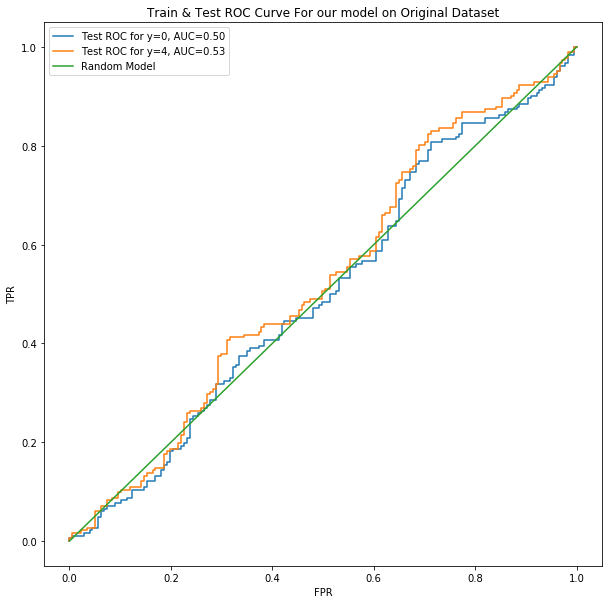

In [50]:
test_proba = nb_original.predict_log_proba(X_test)
test_proba0 = np.array(test_proba)[0,:]
test_proba4 = np.array(test_proba)[1,:]

plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_test, test_proba0, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba0)
plt.plot(fpr, tpr, label='Test ROC for y=0, AUC=%.2f'%auc)

fpr, tpr, thresholds = roc_curve(Y_test, test_proba4, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba4)
plt.plot(fpr, tpr, label='Test ROC for y=4, AUC=%.2f'%auc)

plt.plot([0,1],[0,1], label='Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train & Test ROC Curve For our model on Original Dataset')
plt.legend()
plt.show()

Generating Log probabilities: 100%|██████████| 359/359 [00:00<00:00, 12605.74it/s]


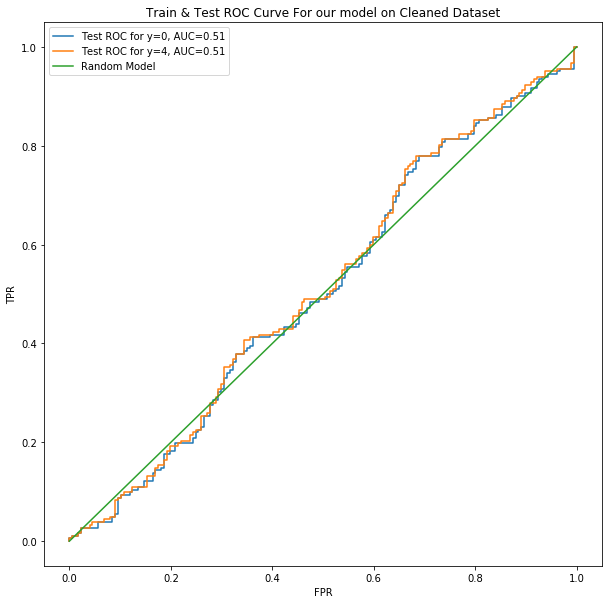

In [51]:
test_proba = nb_cleaned.predict_log_proba(X_test)
test_proba0 = np.array(test_proba)[0,:]
test_proba4 = np.array(test_proba)[1,:]

plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_test, test_proba0, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba0)
plt.plot(fpr, tpr, label='Test ROC for y=0, AUC=%.2f'%auc)

fpr, tpr, thresholds = roc_curve(Y_test, test_proba4, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba4)
plt.plot(fpr, tpr, label='Test ROC for y=4, AUC=%.2f'%auc)

plt.plot([0,1],[0,1], label='Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train & Test ROC Curve For our model on Cleaned Dataset')
plt.legend()
plt.show()

Generating Log probabilities: 100%|██████████| 359/359 [00:00<00:00, 3992.66it/s]


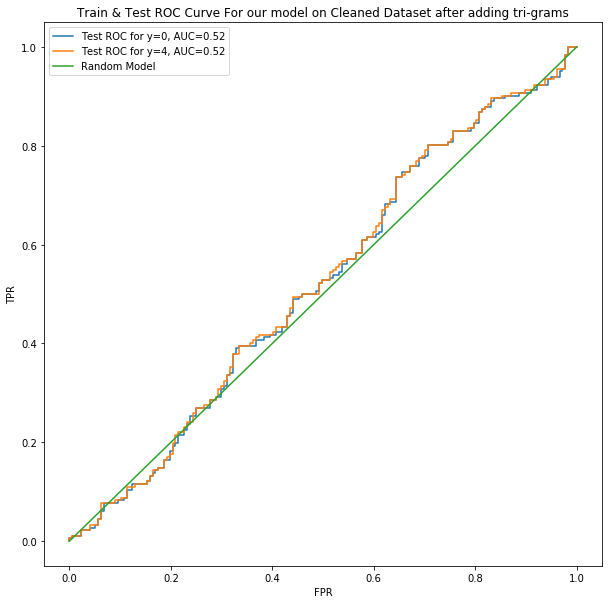

In [70]:
test_proba = nb_tri.predict_log_proba(X_test)
test_proba0 = np.array(test_proba)[0,:]
test_proba4 = np.array(test_proba)[1,:]

plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_test, test_proba0, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba0)
plt.plot(fpr, tpr, label='Test ROC for y=0, AUC=%.2f'%auc)

fpr, tpr, thresholds = roc_curve(Y_test, test_proba4, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba4)
plt.plot(fpr, tpr, label='Test ROC for y=4, AUC=%.2f'%auc)

plt.plot([0,1],[0,1], label='Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train & Test ROC Curve For our model on Cleaned Dataset after adding tri-grams')
plt.legend()
plt.show()

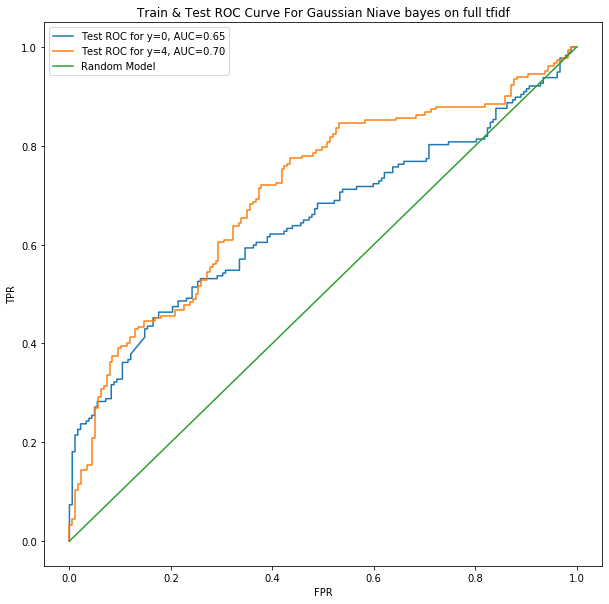

In [71]:
test_proba = myGNB_full.predict_log_proba(X_test_tfidf)
test_proba0 = np.array(test_proba)[:,0]
test_proba4 = np.array(test_proba)[:,1]

plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_test, test_proba0, pos_label=0)
auc=roc_auc_score(Y_test==0, test_proba0)
plt.plot(fpr, tpr, label='Test ROC for y=0, AUC=%.2f'%auc)

fpr, tpr, thresholds = roc_curve(Y_test, test_proba4, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba4)
plt.plot(fpr, tpr, label='Test ROC for y=4, AUC=%.2f'%auc)

plt.plot([0,1],[0,1], label='Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train & Test ROC Curve For Gaussian Niave bayes on full tfidf')
plt.legend()
plt.show()

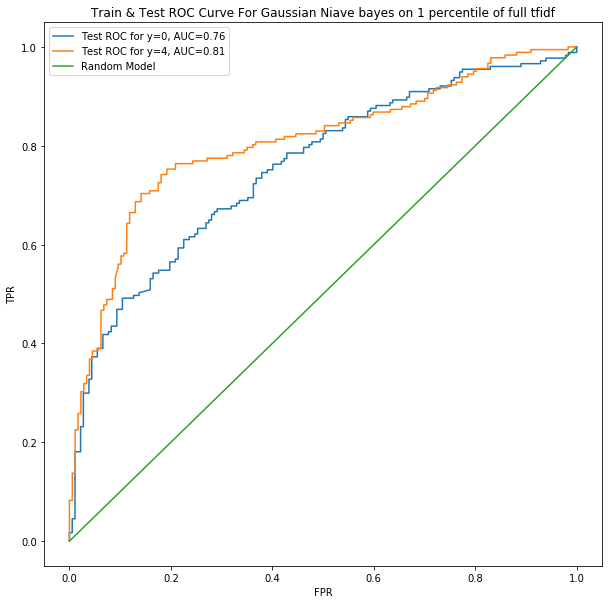

In [72]:
per = SelectPercentile(f_classif, percentile=1).fit(X_train_tfidf, Y_train)

test_proba = myGNB_full_1.predict_log_proba(per.transform(X_test_tfidf))
test_proba0 = np.array(test_proba)[:,0]
test_proba4 = np.array(test_proba)[:,1]

plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_test, test_proba0, pos_label=0)
auc=roc_auc_score(Y_test==0, test_proba0)
plt.plot(fpr, tpr, label='Test ROC for y=0, AUC=%.2f'%auc)

fpr, tpr, thresholds = roc_curve(Y_test, test_proba4, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba4)
plt.plot(fpr, tpr, label='Test ROC for y=4, AUC=%.2f'%auc)

plt.plot([0,1],[0,1], label='Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train & Test ROC Curve For Gaussian Niave bayes on 1 percentile of full tfidf')
plt.legend()
plt.show()

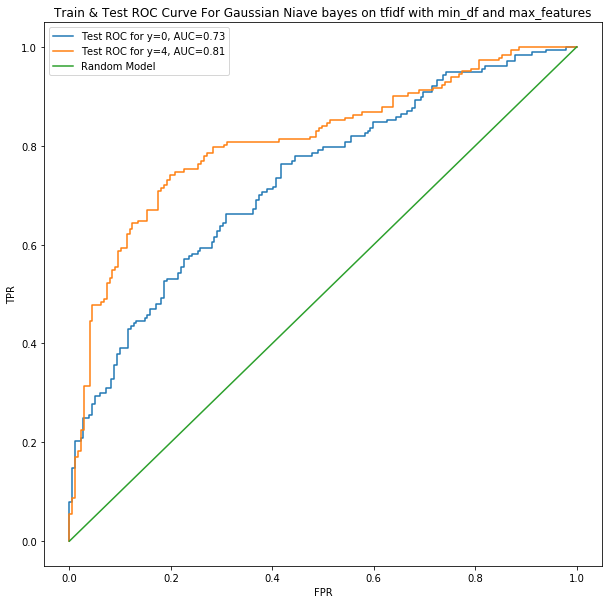

In [73]:
test_proba = myGNB_mindf.predict_log_proba(X_test_tfidf_mindf)
test_proba0 = np.array(test_proba)[:,0]
test_proba4 = np.array(test_proba)[:,1]

plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_test, test_proba0, pos_label=0)
auc=roc_auc_score(Y_test==0, test_proba0)
plt.plot(fpr, tpr, label='Test ROC for y=0, AUC=%.2f'%auc)

fpr, tpr, thresholds = roc_curve(Y_test, test_proba4, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba4)
plt.plot(fpr, tpr, label='Test ROC for y=4, AUC=%.2f'%auc)

plt.plot([0,1],[0,1], label='Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train & Test ROC Curve For Gaussian Niave bayes on tfidf with min_df and max_features')
plt.legend()
plt.show()

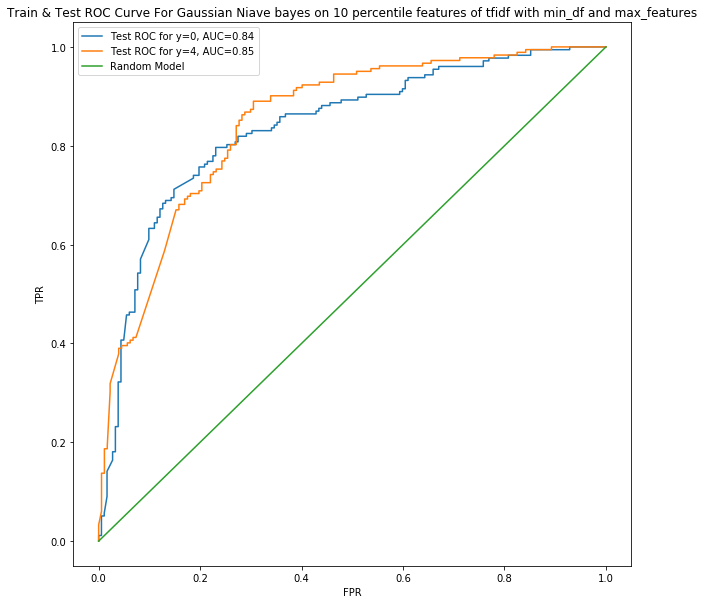

In [75]:
per = SelectPercentile(f_classif, percentile=10).fit(X_train_tfidf_mindf, Y_train)

test_proba = myGNB_mindf_10.predict_log_proba(per.transform(X_test_tfidf_mindf))
test_proba0 = np.array(test_proba)[:,0]
test_proba4 = np.array(test_proba)[:,1]

plt.figure(figsize=(10,10))
fpr, tpr, thresholds = roc_curve(Y_test, test_proba0, pos_label=0)
auc=roc_auc_score(Y_test==0, test_proba0)
plt.plot(fpr, tpr, label='Test ROC for y=0, AUC=%.2f'%auc)

fpr, tpr, thresholds = roc_curve(Y_test, test_proba4, pos_label=4)
auc=roc_auc_score(Y_test==4, test_proba4)
plt.plot(fpr, tpr, label='Test ROC for y=4, AUC=%.2f'%auc)

plt.plot([0,1],[0,1], label='Random Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train & Test ROC Curve For Gaussian Niave bayes on 10 percentile features of tfidf with min_df and max_features')
plt.legend()
plt.show()

* **Observations :**

    * Here we can see that AUC on our original dataset and cleaned dataset is very close to 0.5 hence we can say that our model did performed well in terms of accuracy but it was not confident in detecting classes.

    * We got better ROC curve for GaussianNB on tfidf data. 